# ECS759P Lab5 - Evolutionary Multi-Objective Optimisation (EMOO)


In this notebook we will:



*   Learn how to use the [DEAP](https://deap.readthedocs.io) toolkit to compute and visualise non-dominated sets
*   Implement NSGA-II from scratch
*   Use the DEAP implementation of NSGA-II for a benchmarking problem

Some recap on the concepts we have learnt in the lecture.

**Multi-Objective Optimisation (MOO) Problem**

A lot of optimisation problems involve more than one objective function to be optimised simultaneously. A MOO problem is formally defined as:
$$
\left.\begin{aligned}
\text{Minimise/Maximise} \qquad & f_m(\mathbf{x}), & m=1,2, \dots, M; \\
\text{subject to} \qquad \  & g_j(\mathbf{x}) \geq 0, & j=1,2, \dots, J;  \\
  \qquad \  & h_k(\mathbf{x}) = 0, & k=1,2, \dots, K;  \\
 \qquad \  & x_i^{(L)} \leq x_i \leq x_i^{(U)} & i=1,2, \dots, n;
\end{aligned}\right\rbrace
$$

* Solution $\mathbf{x}$ is a vector of $n$ decision variables: $\mathbf{x} = (x_1, x_2, \cdots ,x_n)^T$
* Variable bounds restrict each decision variable $x_i$ to take a value within a lower $x_i^{(L)}$ and an upper $x_i^{(U)}$ bound. These bounds constitute the *decision (solution, search) space*, $D$
* Associated with the problem are $J$ inequality and $K$ equality constraints
* $g_j(\mathbf{x})$ and $h_k(\mathbf{x})$ are constraint functions
* $\mathbf{f} = (f_1(\mathbf{x}), f_2(\mathbf{x}), ... , f_M(\mathbf{x}))^T$ are $M$ objective functions, each can be minimised or maximised.

A solution $\mathbf{x}$ that satisfies all of the $(J + K)$ constraints and all of the $2n$ variable bounds stated above is called a *feasible solution*. In the presence of constraints, the entire decision variable space $D$ may not be feasible. The set of all the feasible solutions is called the *feasible region*, $S$.

The objective functions constitute a multi-dimensional space, in addition to the usual decision variable space. This additional space is called the *objective space*, $Z$. For each solution $\mathbf{x}$ in the
decision variable space, there exists a point $\mathbf{z}$ in the objective space. Every feasible solution in $S$ can be mapped to a solution in the *feasible objective space*. The mapping takes place between an $n$-dimensional solution vector and an $M$-dimensional objective vector.  



**Optimal solutions in MOO**

In MOO problems there is no unique solution that minimises all the objective functions simultaneously, but there is a set of equally good *trade-off* solutions. These solutions are called *Pareto-optimal solutions*. They form a *non-dominated set* of solutions for the entire search space. The curve formed by joining these solutions is known as a Pareto-optimal front.

Solution $\mathbf{x}^{(1)}$ dominates $\mathbf{x}^{(2)}$, if
* $\mathbf{x}^{(1)}$ is **no worse** than $\mathbf{x}^{(2)}$ in all objectives
* $\mathbf{x}^{(1)}$ is **strictly better** than $\mathbf{x}^{(2)}$ in at least one objective

Among a set of solutions $P$, the non-dominated set of solutions $P'$ are those that are not dominated by any member of the set $P$.

**Objectives in MOO**

1. Find a set of solutions as close as possible to the Pareto-optimal front
2. Find a set of solutions as diverse as possible

DEAP is a popular evolutionary computation library that includes implementation of genetic algorithms (GAs), tools for genetic programming, MOO and parallelisation.

We start with standard imports.

In [ ]:
import time, array, random, copy, math
import numpy as np
import pandas as pd

We also import some visualisation packages.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('notebook')

Finally, we import the required DEAP modules.

In [ ]:
from deap import algorithms, base, benchmarks, tools, creator

# set the seed for reproducibility
random.seed(a=123)

## Visualising the Pareto-optimal front

`creator` factory creates new classes at run-time.

We will first call its function `create` with two arguments: the name of the newly created class and the base class that the new class should inherit from. Subsequent arguments become class attributes.

The first line creates a Fitness class. This fitness minimises two objectives (hence both respective weights are negative).

The second line creates an Individual class. Our individual will be a simple list of doubles. We hence set the double typecode (`d` for double). The class has the previously created FitnessMin as its fitness attribute.

In [ ]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual", array.array, typecode='d',
               fitness=creator.FitnessMin)

We will consider the following two-objective Dent benchmarking problem. Both objectives are to be minimised. Solutions (individuals) contain two decision variables with the bounds as indicated below.

$$
\begin{array}{rl}
\text{Minimise} & f_1(\mathbf{x}),f_2(\mathbf{x}) \\
\text{where} & f_1(\mathbf{x}) = \frac{1}{2}\left( \sqrt{1 + (x_1 + x_2)^2} \sqrt{1 + (x_1 - x_2)^2} + x_1 -x_2\right) + d,\\
 & f_2(\mathbf{x}) = \frac{1}{2}\left( \sqrt{1 + (x_1 + x_2)^2} \sqrt{1 + (x_1 - x_2)^2} - x_1 -x_2\right) + d,\\
& d = \lambda e^{-\left(x_1-x_2\right)^2}\\
\text{subject to}  \  & -1.5 \leq x_1 \leq 1.5 \\
\  & -1.5 \leq x_2 \leq 1.5 \\
\end{array}
$$

In [ ]:
# source https://github.com/DEAP/deap/blob/master/deap/benchmarks/__init__.py

def dent(individual, lambda_ = 0.85):
    d = lambda_ * math.exp(-(individual[0] - individual[1]) ** 2)
    f1 = 0.5 * (math.sqrt(1 + (individual[0] + individual[1]) ** 2) +
                math.sqrt(1 + (individual[0] - individual[1]) ** 2) +
                individual[0] - individual[1]) + d
    f2 = 0.5 * (math.sqrt(1 + (individual[0] + individual[1]) ** 2) +
                math.sqrt(1 + (individual[0] - individual[1]) ** 2) -
                individual[0] + individual[1]) + d
    return f1, f2

We set the decision bounds and the solution dimensionality accordingly.

In [ ]:
BOUND_LOW, BOUND_UP = -1.5, 1.5
# two-dimensional solutions
NDIM = 2

The method below will uniformely sample individuals respecting the bounds.

In [ ]:
def uniform(low, up, dimensionality=1):
    return [random.uniform(a, b) for a, b in zip([low] * dimensionality, [up] * dimensionality)]

The `toolbox` stores useful functions. They are registered by providing the alias and the function itself. If you specify any arguments, they will be passed to the function when the alias is called.

We register four functions:

*   `attr_float` calls the solution sampling method
*   `individual` generates an individual using the method `attr_float()`
*   `population` returns a new population in a list
*   `evaluate`  returns fitness values of an individual. The function arguments are not specified here. They will be applied each individual separately.

You may write the evaluation function yourself (like we did above with `dent`) or take it from the provided set of benchmarking problems (https://deap.readthedocs.io/en/master/api/benchmarks.html). We will see how to do it later.

In [ ]:
toolbox = base.Toolbox()
toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", dent)

We will create a sample population using `meshgrid`. This function returns the coordinates of solutions which construct a rectangular grid.

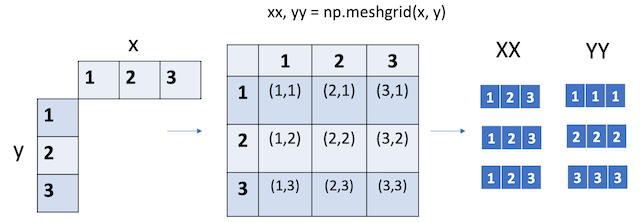

In [ ]:
# set the count of points to pick in each dimension
dim_sample_count = 50
# choose equally distanced coordinates in each dimension
coordinates = np.arange(BOUND_LOW, BOUND_UP, (BOUND_UP - BOUND_LOW)/dim_sample_count)

# build a rectangular grid by creating every possible combination of coordinates in two dimensions
# get a list of two arrays (all the x-coordinates and all the y-coordinates) with the dimensionality (dim_sample_count, dim_sample_count) each
# (see the figure above)
grid = np.meshgrid(coordinates, coordinates)

In [ ]:
# get each array flattened, i.e. dimensionality (dim_sample_count*dim_sample_count)
dimension_points = list()
for i in range(len(grid)):
    x_i = grid[i]
    dimension_points.append(x_i.reshape(dim_sample_count*dim_sample_count))

We call the `population` function to create a population.

In [ ]:
demonstration_population = toolbox.population(n=dim_sample_count**NDIM)

print("Population is of type %s and contains %d individuals\n%s" % (type(demonstration_population), len(demonstration_population), demonstration_population[:10]))

In [ ]:
# assign our grid coordinates to decision variables of the individuals to produce a grid of solutions
for i, ind in enumerate(demonstration_population):
    for j in range(len(dimension_points)):
        ind[j] = dimension_points[j][i]

We evaluate our solutions with the fitness function.

In [ ]:
fitnesses = toolbox.map(toolbox.evaluate, demonstration_population)
for ind, fit in zip(demonstration_population, fitnesses):
    ind.fitness.values = fit

We pick a solution that we will assess (this will be point (0.5, 0.5)) and get its fitness.

In [ ]:
trg_solution = toolbox.population(n=1)[0]
trg_solution[0] = 0.5
trg_solution[1] = 0.5

In [ ]:
trg_solution.fitness.values = toolbox.evaluate(trg_solution)
print(trg_solution.fitness.values)

To find Pareto-optimal solutions, we first need to implement a dominance test.

**Q. Implement the dominance test function below.**

In [ ]:
def dominance_test(solution1,solution2):
    """
    solution1: numpy array of shape (NDIM)
    solution2: numpy array of shape (NDIM)
    Returns:
        True if solution1 dominates solution2
    """
    # TO DO
    if type(solution1) is not np.ndarray:
        solution1 = solution1.fitness.values
        solution2 = solution2.fitness.values

    no_worse = solution1[0] <= solution2[0] and solution1[1] <= solution2[1]
    strictly_better = solution1[0] < solution2[0] or solution1[1] < solution2[1]
    return no_worse and strictly_better
    # TO DO

We will now get the set of solutions that are dominated by `trg_solution`, the set that dominates it and the rest.

In [ ]:
dominated_by_trg_solution = [solution for solution in demonstration_population if dominance_test(trg_solution, solution)]
dominates_trg_solution = [solution for solution in demonstration_population if dominance_test(solution, trg_solution)]
rest = [solution for solution in demonstration_population if not solution in dominated_by_trg_solution and not solution in dominates_trg_solution]

We plot the points in the decision and objective spaces.

In [ ]:
def plot_dent():

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)

    for ind in dominates_trg_solution:
      plt.plot(ind[0], ind[1], 'm.')
    for ind in dominated_by_trg_solution:
      plt.plot(ind[0], ind[1], 'c.')
    for ind in rest:
      plt.plot(ind[0], ind[1], 'y.', ms=3)

    plt.plot(trg_solution[0], trg_solution[1], 'bo', ms=6);
    plt.xlabel('x1');
    plt.ylabel('x2');
    plt.title('Decision (Search) space');
    plt.subplot(1,2,2)

    for ind in dominates_trg_solution:
      plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'm.', alpha=0.7)
    for ind in dominated_by_trg_solution:
      plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'c.', alpha=0.7)
    for ind in rest:
      plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'y.', alpha=0.7, ms=3)

    plt.plot(trg_solution.fitness.values[0], trg_solution.fitness.values[1], 'bo', ms=6);
    plt.xlabel('f1(x)');
    plt.ylabel('f2(x)');
    plt.xlim((0.5,3.6));
    plt.ylim((0.5,3.6));
    plt.title('Objective space');
    plt.tight_layout()

The solutions that dominate `trg_solution` are in magenta, those that it dominates are in cyan and the rest are incomparable.

In [ ]:
plot_dent()

We can also find and display the Pareto-optimal front using DEAP. We will get only the best front (also the first in the returned lists of fronts). It is highlighted in blue in the plot below.

In [ ]:
non_dominated_front = tools.sortNondominated(demonstration_population, k=len(demonstration_population), first_front_only=True)[0]

In [ ]:
plt.figure(figsize=(5,5))
for ind in demonstration_population:
    plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', ms=3, alpha=0.5)
for ind in non_dominated_front:
    plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'bo', alpha=0.74, ms=5)
plt.title('Pareto-optimal front')

## Non-Dominated Sorting Genetic Algorithm (NSGA-II)

* NSGA-II algorithm is one of the key algorithms in Evolutionary MOO
* It uses a diversity-preserving strategy together with an elite-preservation strategy


Given the number of iterations $T$ and population size $N$ as parameters, the algorithm performs the following steps:


1.   Combine parent and offspring populations $R_t=P_t \cup Q_t$. Initial population $Q_1$ is created by crossover and mutation from the parent population. Perform a non-dominated sorting to $R_t$ and identify different fronts.
2.   Set new $P_{t+1}= ∅$. Set $i = 1$.
3.   Until $|P_{(t+1)}|+|F_i|< N$, perform $P_{(t+1)}=P_{(t+1)} \cup F_i$ and increment $i = i + 1$.
4.   Perform crowding sort for $F_i$ and include the best $(N -|P_{(t+1)}|)$ solutions to $P_{(t+1)}$ using the crowding distance estimates.
5.  Create offspring population $Q_{(t+1)}$ from $P_{(t+1)}$ by using the crowded tournament selection.
6.  Perform crossover and mutation over $Q_{(t+1)}$.  

Below we implement the algorithm from scratch. We will start with the most important functions that compute the crowding distance, perform non-dominated sorting and crowded tournament. We will then look into creating the algorithm loop.

Crossover and mutation operations are given and implemented as follows.

In [ ]:
def crossover(population):
    """
    population: numpy array of shape (N, NDIM)
    Returns:
        offspring_population: numpy array of shape (N, NDIM)
    """

    offspring_population = np.zeros((population.shape))

    # we iterate over the population taking two members at a time
    for i in range(0, population.shape[0]-1, 2):

        # we select two solutions randomly from the whole population
        rnd1 = np.random.randint(0, population.shape[0])
        rnd2 = np.random.randint(0, population.shape[0])

        # we randomly select a crossover point
        point = np.random.randint(1, population.shape[1])

        offspring_population[i, :point] = population[rnd1, :point]
        offspring_population[i, point:] = population[rnd2, point:]
        offspring_population[i+1, :point] = population[rnd2, :point]
        offspring_population[i+1, point:] = population[rnd1, point:]

    return offspring_population

def mutation(population, low, up, mutation_strength=0.1):
    """
    population: numpy array of shape (N, NDIM)
    low: float for the lower decision variable bound
    up: float for the upper decision variable bound
    mutation_strength: float for the amount of added noise

    Returns:
        offspring_population: numpy array of shape (N, NDIM)
    """
    offspring_population = population.copy()
    # create random noise
    mutation = (np.random.uniform(low, up, (offspring_population.shape)) - 0.5) * mutation_strength
    # add noise
    offspring_population += mutation
    # make sure we respect the bounds
    offspring_population = np.clip(offspring_population, low, up)

    return offspring_population

**Crowding Distance**

The distance is computed as follows:

1.   For each solution $i$ in the non-dominated front $F$, where $l=|F|$, assign $d_i=0$
2.   For each objective function $m = 1, 2, ⋯, M$:

  (a)   Sort the set in the worst order of $f_m$ to find the sorted indices vector $I_m=sort(f_m, >)$

  (b)   Assign a large distance to the boundary solutions, $d_{I_1^m} = d_{I_l^m}= ∞$

  (c) For all the other solutions j=2 to (l-1), assign:
$d_{I_j^m} = d_{I_j^m} + \frac{f_m^{(I_{j+1}^m)}-f_m^{(I_{j-1}^m)}}{f_m^{max}-f_m^{min}}$



**Hint**: you can use the max objective values to assign large distances.


**Q. Implement those steps in the function below.**

In [ ]:
def compute_crowding_distance(front_fitness_values, F_MIN, F_MAX):
    """
    front_fitness_values: numpy array of shape (l, NDIM)
    F_MIN: minimum values per objective, array of length 2
    F_MAX: maximum values per objective, array of length 2

    Returns:
        crowding_distance: numpy array of shape (l, NDIM)
    """
    # TO DO
    # get l
    l = front_fitness_values.shape[0]
    # get number of objective functions
    obj_number = front_fitness_values.shape[1]

    # assign initial d to zero
    distance_matrix = np.zeros((l, obj_number))
    # loop over objectives
    for i in range(obj_number):

        # sort the fitness values in the worst order (step 2a)
        sorted_fitness_values = np.sort(front_fitness_values[:,i])
        # get indexes of the original array in the order of the sorted array
        sorted_values_index = np.argsort(front_fitness_values[:,i])

        crowding_results = np.zeros((l))

        # assign the largest distance to the boundaries (step 2b)
        crowding_results[0] =  F_MAX[i]
        crowding_results[l - 1] = F_MAX[i]

        # compute the crowding distance (step 2c)
        for j in range(1, l - 1):
            crowding_results[j] = (sorted_fitness_values[j+1] - sorted_fitness_values[j-1]) / (F_MAX[i] - F_MIN[i])

        # update the distance matrix using the original index information
        for new_ind, old_ind in enumerate(sorted_values_index):
            distance_matrix[old_ind, i] = crowding_results[new_ind]

    # print(distance_matrix)
    # sum distances across objectives
    crowding_distance = np.sum(distance_matrix, axis=1)

    return crowding_distance
    # TO DO

**Q. Test your implementation with the front given during the lecture.**

In [ ]:
f_min = [0.1, 0.0]
f_max = [1.0, 60.0]
test_front = np.array([[0.31, 6.1], [0.22, 7.09], [0.79, 3.97], [0.27, 6.93]])

# TO DO
crowding_distance_array = compute_crowding_distance(test_front, f_min, f_max)
print(crowding_distance_array)
# TO DO

In [ ]:
f_min = [10, 0.25]
f_max = [100, 0.80]
test_front = np.array([[16, 0.30], [17, 0.32], [30, 0.5]])

# TO DO
crowding_distance_array = compute_crowding_distance(test_front, f_min, f_max)
print(crowding_distance_array)
# TO DO

**Q. Implement the function below to perform non-dominated sorting of the population.**

**Hint**: use may call the function you wrote earlier.

Recall that among a set of solutions $P$, the non­-dominated set of solutions $P'$ containts those solutions that are **not** dominated by any member of the set $P$.

In [ ]:
def non_dominated_sorting(fitness_values):
    """
    fitness_values: numpy array of shape (N, NDIM)
    Returns:
        rank_dict: dictionary {int rank: list of indices}, rank starts from 1
    """
    # TO DO
    N = fitness_values.shape[0]
    selected_index = set()
    rank_dict = dict()

    rank = 1

    # until all the population is sorted
    while len(selected_index) < N:

      new_non_dominated_front_index = list()
      for i in range(N):
          # we skip the solutions from the previous non-dominated fronts
          if i in selected_index:
              continue
          non_dominated = True
          for j in range(N):
              # we skip selected solutions
              if j in selected_index:
                continue
              # if another member (j) of the set dominates i then i is not in the non-dominated set
              if dominance_test(fitness_values[j], fitness_values[i]):
                  non_dominated = False
                  break
          if non_dominated:
              new_non_dominated_front_index.append(i)

      rank_dict[rank] = new_non_dominated_front_index
      selected_index.update(new_non_dominated_front_index)
      rank += 1

    return rank_dict
    # TO DO

**Q. Test your implementation with the population given during the lecture. Print out all the fronts.**

In [ ]:
test_fitness_values = np.array([[0.31, 6.1], [0.43, 6.79], [0.22, 7.09], [0.59, 7.85],
                       [0.66, 3.65], [0.83, 4.23], [0.21, 5.9], [0.79, 3.97],
                       [0.51, 6.51], [0.27, 6.93], [0.58, 4.52], [0.24, 8.54]])
solution_ids = np.array([1, 2, 3, 4, 5, 6, "a", "b", "c", "d", "e", "f"])

# TO DO
front_index_dict = non_dominated_sorting(test_fitness_values)
print("Front 1")
print(solution_ids[front_index_dict[1]])
print("Front 2")
print(solution_ids[front_index_dict[2]])
print("Front 3")
print(solution_ids[front_index_dict[3]])
print("Front 4")
print(solution_ids[front_index_dict[4]])
# TO DO

Recall that a solution $i$ wins a tournament with another solution $j$ if any of the following conditions are true:

1.  If solution $i$ has a better rank, that is, $r_i < r_j$

2.  If they have the same rank but solution $i$ has a better crowding distance than solution $j$, i.e., $r_i = r_j$ and $d_i > d_j$

Both $i$ and $j$ can be selected randomly from the initial population.

In [ ]:
def crowded_tournament(population, rank_list, F_MIN, F_MAX):
    """
    population: numpy array of shape (N, NDIM)
    rank_list: numpy array of shape (N, NDIM)
    fitness_values: numpy array of shape (N, NDIM)
    F_MIN: minimum values per objective, array of length 2
    F_MAX: maximum values per objective, array of length 2

    Returns:
        parent: numpy array of shape (N, NDIM)
    """
    fitness_values = compute_fitness(population)
    crowding_distance = compute_crowding_distance(fitness_values, F_MIN, F_MAX)
    N = population.shape[0]
    parent = np.zeros(population.shape)

    for i in range(N):

        # we pick two solutions randomly
        solution1 = np.random.randint(0, N)
        solution2 = np.random.randint(0, N)
        selected_solution = solution1

        # if rank is the same we check the crowding distance
        if rank_list[solution1] == rank_list[solution2]:
            if crowding_distance[solution2] > crowding_distance[solution1]:
                selected_solution = solution2
        # otherwise we check the rank
        else:
            if rank_list[solution2] < rank_list[solution1]:
                selected_solution = solution2

        parent[i] = population[selected_solution]
    return parent

Now we can build a loop to fill a new population $P_{t+1}$.

In [ ]:
def fill_new_population(population, fitness_values, population_size, F_MIN, F_MAX):
    """
    population: numpy array of shape (2N, NDIM)
    fitness_values: numpy array of shape (2N, NDIM)
    population_size: int, size of the population N to return
    F_MIN: minimum values per objective, array of length 2
    F_MAX: maximum values per objective, array of length 2

    Returns:
        selected_population:  numpy array of shape (N, NDIM)
        selected_rank: numpy array of shape (N)
    """
    # get the indices of the solutions per front (step 1 of the main algorithm)
    front_index_dict = non_dominated_sorting(fitness_values)

    # new population is empty (step 2 of the main algorithm)
    selected_population = list()
    # rank of each selected solution
    selected_rank = list()

    # we start with the best rank
    rank = 1

    # iterate until the population is filled (step 3 of the main algorithm)
    while len(selected_population) < population_size:

        # get the next non-dominated set of the relevant rank
        new_non_dominated_front_index = front_index_dict[rank]
        new_non_dominated_front = population[new_non_dominated_front_index]
        new_non_dominated_front_fitness = fitness_values[new_non_dominated_front_index]

        # compute the size of the new population after adding a new front
        new_population_size = len(selected_population) + len(new_non_dominated_front)

        # check the size of population after adding a new front
        # if larger than population size then remove some solutions from the new front based on the crowding distance (step 4)
        if new_population_size > population_size:

            places_left = population_size - len(selected_population)
            # compute the crowding distance
            crowding_distance = compute_crowding_distance(new_non_dominated_front_fitness, F_MIN, F_MAX)

            # select the necessary count of solutions with the highest distance
            selected_solution_index = crowding_distance.argsort()[-places_left:]
            selected_non_dominated_front = new_non_dominated_front[selected_solution_index]
            new_selected_rank = np.array([rank] * len(selected_non_dominated_front))

            # merge the reduced front with the current population (step 4 of the main algorithm)
            selected_population.extend(selected_non_dominated_front)
            selected_rank.extend(new_selected_rank)
        else:
            # merge the entire front with the current population (step 3 the main algorithm)
            selected_population.extend(new_non_dominated_front)
            new_selected_rank = np.array([rank] * len(new_non_dominated_front))
            selected_rank.extend(new_selected_rank)

        rank += 1

    return np.asarray(selected_population), np.asarray(selected_rank)

We build a helper method to compute fitness values.

In [ ]:
def compute_fitness(population):
    """
    population: numpy array of shape (2N, NDIM)
    Returns:
        fitness_values:  numpy array of shape (2N, NDIM)
    """
    fitness_values = np.zeros((population.shape))
    for i,x in enumerate(population):
      obj1, obj2 = dent(x)
      fitness_values[i,0] = obj1
      fitness_values[i,1] = obj2
    return fitness_values

We will finally create the main NSGA-II loop.

Run the code and compare your result to the result obtained earlier for the same problem.

In [ ]:
# we define the parameters
NDIM = 2
BOUND_LOW, BOUND_UP = -1.5, 1.5
N = 70
T = 70   # number of iterations
F_MIN = [0.58, 0.58] # minimum values per objective
F_MAX = [3.58, 3.58] # maximum values per objective

# initialise the population by uniform sampling
population = np.zeros((N, NDIM))
for i in range(N):
  population[i,:] = np.array(uniform(BOUND_LOW, BOUND_UP, dimensionality=NDIM))
mating_pool = population

# main loop
for i in range(T):

    # create new offspring population (step 6 of the main algorithm)
    offspring_crossed = crossover(mating_pool)
    offspring = mutation(offspring_crossed, BOUND_LOW, BOUND_UP)
    # combine parent and offspring population (step 1 of the main algorithm)
    population = np.append(population, offspring, axis=0)
    # compute objective functions
    fitness_values = compute_fitness(population)
    # fill in a new population from the non-dominated fronts of the combined population (steps 1-4 of the main algorithm)
    new_population, rank = fill_new_population(population, fitness_values, N, F_MIN, F_MAX)
    # create new offspring with crowded tournament selection (step 5 of the main algorithm)
    mating_pool = crowded_tournament(new_population, rank, F_MIN, F_MAX)
    population = new_population

# show the non-dominated set found
fitness_values = compute_fitness(population)
index = np.arange(population.shape[0]).astype(int)
final_non_dominated_front_index = non_dominated_sorting(fitness_values)[1]
fitness_values = fitness_values[final_non_dominated_front_index]

plt.scatter(fitness_values[:, 0],fitness_values[:, 1], label='Pareto optimal front')
plt.legend(loc='best')
plt.xlabel('f1')
plt.ylabel('f2')
plt.grid(visible=1)
plt.show()

## NSGA-II in DEAP

We will try now the DEAP implementation of NSGA-II on the more complex [DTLZ3](https://deap.readthedocs.io/en/master/api/benchmarks.html?highlight=dtlz3#deap.benchmarks.dtlz3) problem (see visualisation below). This is one of the benchmarking problems used in the MOO community. It introduces a lot of local optima that run in parallel to the global optima. It is well suited to test algorithms. DTLZ problems can be configured with any amount of objectives. We will choose two for optimised visualisation.

From [Pymoo](https://pymoo.org/problems/many/dtlz.html)
<div align='center'><img src='https://pymoo.org/_images/problems_many_dtlz_26_1.png' width="38%" align='center'/></div>


We initialise a new `toolbox` instance.

In [ ]:
toolbox = base.Toolbox()

We define our problem as a two-objective DTLZ3 instance.

In [ ]:
NDIM = 30
BOUND_LOW, BOUND_UP = 0.0, 1.0

We will register the necessary functions for sampling, creation of individuals and population, evaluation, as well for selection, mating (crossover) and mutation operators.

Following the original NSGA-II algorithm, we use the simulated binary crossover (`cxSimulatedBinaryBounded`). It simulates the single-point crossover operator for real-coded GA. We also use Polynomial mutation (`mutPolynomialBounded`)(see Chapter 4, section 4.2.2, p109 and p120 of Deb:  Multi-Objective Optimization using Evolutionary Algorithms, John Wiley & Sons, 2001).

We register the NSGA-II selection operator.

In [ ]:
toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", lambda ind: benchmarks.dtlz3(ind, 2))

# we can specify different parameters of the relevant operators (see https://deap.readthedocs.io/en/master/api/tools.html)
# eta is the crowding degree of the crossover:
# high eta will produce children resembling to their parents, while a small eta will produce more diverse solutions
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
# indpb is the independent probability for each variable to be mutated
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

toolbox.register("select", tools.selNSGA2)

`toolbox` can also store configurations.

In [ ]:
toolbox.pop_size = 50
toolbox.max_gen = 1000
toolbox.mut_prob = 0.2

DEAP's `algorithms.eaMuPlusLambda` implements an elitist EA where the next generation population is selected from both the offspring and the population. We will use it with the NSGA-II selection operator as defined above.

In [ ]:
def run_nsga_ii(toolbox, verbose=False):
    pop = toolbox.population(n=toolbox.pop_size)
    pop = toolbox.select(pop, len(pop))

    # we register the Statistics object for the new population
    # we can then get the statistics via the returned log
    pop_stats = tools.Statistics(key=np.copy)
    pop_stats.register('pop', np.copy)
    pop_stats.register('fitness', lambda x : [benchmarks.dtlz3(ind, 2) for ind in x])


    # some of the parameters that are worth noting
    # mu is number of individuals to select for the next generation
    # cxpb is the probability of mating two individuals
    # mutpb is the the probability of mutating an individual
    # ngen is the number of generations
    return algorithms.eaMuPlusLambda(pop, toolbox, mu=toolbox.pop_size,
                                     lambda_=toolbox.pop_size,
                                     cxpb=1-toolbox.mut_prob,
                                     mutpb=toolbox.mut_prob,
                                     stats=pop_stats,
                                     ngen=toolbox.max_gen,
                                     verbose=verbose)

We will now run NSGA-II.

In [ ]:
%time result, log = run_nsga_ii(toolbox)

We get the solutions and fitness values from the last generation in the log.

In [ ]:
pop = log[-1]['pop']
fits = log[-1]['fitness']

We can finally plot the optimal front found.

In [ ]:
fig, ax = plt.subplots(1, figsize=(4,4))
for f_values in fits:
    ax.scatter(f_values[0], f_values[1], marker="o", s=48, color='blue')
plt.xlabel('f1(x)')
plt.ylabel('f2(x)')

We will also visualise the progress of the algorithm in a video.

In [ ]:
%time results, log = run_nsga_ii(toolbox)

We create a function to plot the best front for each iteration of the algorithm.

In [ ]:
def animate(frame_index, log):
    ax.clear()

    fits = log[frame_index]['fitness']
    for f_values in fits:
        ax.scatter(f_values[0], f_values[1], marker="o", s=48, color='blue')

    ax.set_title('t=' + str(frame_index))
    ax.set_xlabel('f1(x)')
    ax.set_ylabel('f2(x)')
    return []

We finally use the Matplotlib functionalities to animate the process.

In [ ]:
fig = plt.figure(figsize=(4,4))
ax = fig.gca()
anim = animation.FuncAnimation(fig, lambda i: animate(i, log), frames=len(log), interval=60, blit=True)
plt.close()

We can watch how the algorithm advances from the local optimal fronts to the global one. Note that loading may take a while.

In [ ]:
HTML(anim.to_html5_video())

## Advanced: Hyperparameter search

**Q: Run the algorithm with different values of the population size. Make conclusions about the performance.**

We will define three experiments with different population sizes, as well as the total evaluations per experiment.

In [ ]:
pop_sizes = (10,50,150)
total_evals = 500

We also need a wrapper for the evaluation function to enable parallelisation later.

In [ ]:
def eval_helper(ind):
      return benchmarks.dtlz3(ind, 2)

toolbox.register("evaluate", eval_helper)

We can now replicate this toolbox instance in a list.

In [ ]:
toolboxes=list([copy.deepcopy(toolbox) for _ in range(len(pop_sizes))])

We will set the population sizes in `toolboxes`. We add an `experiment_name` to each `toolbox`. Maximum number of iterations is defined by the population size (larger population size means less generations).

In [ ]:
for pop_size, toolbox in zip(pop_sizes, toolboxes):
    toolbox.pop_size = pop_size
    # define maximum generations per run
    toolbox.max_gen = int(total_evals / pop_size)
    toolbox.experiment_name = "pop_size=" + str(toolbox.pop_size) + ";" + "max_gen=" + str(toolbox.max_gen)

In [ ]:
for toolbox in toolboxes:
    print(toolbox.experiment_name, toolbox.pop_size, toolbox.max_gen)

We will evaluate our stochastic models on the basis of 30 runs.

In [ ]:
number_of_runs = 30

Local parallelisation can be achieved with Python's [`concurrent.futures`](https://docs.python.org/3/library/concurrent.futures.html) module.

We can use the progress bar from [IPython widgets](http://nbviewer.ipython.org/github/jvns/ipython/blob/master/examples/Interactive%20Widgets/Index.ipynb).

In [ ]:
from ipywidgets import IntProgress
from IPython.display import display

Parallelisation can be problematic if `lambda` is used. Hence we will write a wrapper function.

In [ ]:
def run_algo_wrapper(toolbox):
    result, log = run_nsga_ii(toolbox)
    return log[-1]['fitness']

In [ ]:
%%time
# import the library to run tasks simultaneously
import concurrent.futures
progress_bar = IntProgress(description="000/000", max=len(toolboxes)*number_of_runs)
display(progress_bar)

results = {toolbox.experiment_name:[] for toolbox in toolboxes}
with concurrent.futures.ProcessPoolExecutor() as executor:
    futures = {executor.submit(run_algo_wrapper, toolbox): toolbox
               for _ in range(number_of_runs)
               for toolbox in toolboxes}

    for future in concurrent.futures.as_completed(futures):
        current_tb = futures[future]
        # we add all the optimal solutions from the current run
        results[current_tb.experiment_name].extend(future.result())
        progress_bar.value +=1
        progress_bar.description = "%03d/%03d:" % (progress_bar.value, progress_bar.max)

**Q: Use the code above to plot results per experiment.**

In [ ]:
# TO DO
for experiment_name in results:
  fits = results[experiment_name]
  fig, ax = plt.subplots(1, figsize=(4,4))

  for f_values in fits:
    ax.scatter(f_values[0], f_values[1], marker="o", s=48, color='blue')

  ax.set_title(str(experiment_name))
  plt.xlabel('f1(x)')
  plt.ylabel('f2(x)')
  # TO DO

We acknowledge the help of [DEAP library tutorial material](https://deap.readthedocs.io/en/master) in the preparation of this lab session.